In [1]:
import cvxpy as cp
import numpy as np
# Define and solve the CVXPY problem.
n = 10
A = np.random.randn(2, n)
u = np.random.randn(2, 1)
y = cp.Variable(n)
Ay = A @ y
obj = cp.sum_squares(Ay) + u.T@Ay
constraints =  [cp.norm2(y[:5]) <= 1, cp.norm2(y[5:]) <= 1]
prob = cp.Problem(cp.Minimize(obj), constraints)
prob.solve(solver=cp.GUROBI, verbose=False)
print("\nThe optimal value is", prob.value)
print("The optimal x is")
print(y.value)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-28

The optimal value is -0.43231279239753617
The optimal x is
[ 0.05063963 -0.04315767 -0.09285631 -0.06775638  0.06076909 -0.05372493
 -0.14235034 -0.02289263  0.14161058  0.03591744]


In [4]:
prob.solve(solver=cp.GUROBI, verbose=True)

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Sep 01 10:11:36 AM: Your problem has 10 variables, 2 constraints, and 0 parameters.
(CVXPY) Sep 01 10:11:36 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 01 10:11:36 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 01 10:11:36 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 01 10:11:36 AM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Sep 01 10:11:36 AM: Finished problem compilation (took

-0.43231279239753617

# test dual

In [2]:
import argparse
import sys
sys.path.append("../..")
from src.funcs.regularizer import  NatOG
from src.utils import gen_chain_group
import numpy as np

def get_config():
    parser = argparse.ArgumentParser()
    # IPG solver configurations
    parser.add_argument("--ipg_save_log", default=True, type=lambda x: (str(x).lower()
                        in ['true', '1', 'yes']), help="whether save the log of the ipg solver.")
    parser.add_argument("--exact_pg_computation", default=False, type=lambda x: (str(x).lower()
                        in ['true', '1', 'yes']), help="Mimic to the exact computation of the proximal operator.") 
    parser.add_argument("--exact_pg_computation_tol", type=float, default=1e-15, help="Deisred error tolerance.")                                                                      

    parser.add_argument("--ipg_do_linesearch", default=True, type=lambda x: (str(x).lower()
                        in ['true', '1', 'yes']), help="Whether do linesearch in the projected gradient ascent.")
    parser.add_argument("--ipg_linesearch_eta", type=float, default=1e-4, help="eta of the linesearch.")
    parser.add_argument("--ipg_linesearch_xi", type=float, default=0.8, help="xi of the linesearch.")
    parser.add_argument("--ipg_linesearch_beta", type=float, default=1.2, help="beta of the linesearch.")
    parser.add_argument("--ipg_linesearch_limits", type=int, default=100, help="max attempts of the linesearch.")
    
    parser.add_argument("--ipg_strategy", type=str, default="diminishing", choices=["diminishing"], 
        help="Strategy to inexactly evaluate the proximal operator.\ndiminishing: c * np.log(k+1) / k**delta")
    parser.add_argument("--ipg_diminishing_c", type=float, default=1, help="c of c * np.log(k+1) / k**delta")
    parser.add_argument("--ipg_diminishing_delta", type=float, default=2, help="delta of c * np.log(k+1) / k**delta")
    config = parser.parse_args("")
    return config

In [4]:
groups = [[0,1,2], [1,2,3], [0,2,4]]
print('using:', groups)
config = get_config()
r = NatOG(groups, penalty=1.0, config=config, weights=np.array([1,100,1]))
print(r.A.todense())
print(r.xdim)
np.random.seed(0)
x0 = np.random.randn(r.xdim, 1)
print(r.func(x0))
dk=np.random.randn(r.xdim, 1)
alphak = 1.0
xtrial, ytrial = r.compute_inexact_proximal_gradient_update(xk=x0, alphak=alphak, dk=dk, 
                                            y_init=None, stepsize_init=None, 
                                            ipg_kwargs={'iteration':100000})
print(f'target duality gap:{r.targap:.3f} | subsolver status:{r.flag} | aoptim:{r.aoptim:.3f}')
print('init x             :', x0.T)
print('approxmate solution:', xtrial.T)
Aytrial = r.A @ ytrial
uk = x0 - alphak * dk
dual = alphak/2 * Aytrial.T@Aytrial + uk.T@Aytrial
print('dual               :', dual)

using: [[0, 1, 2], [1, 2, 3], [0, 2, 4]]
[[1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
5
252.58908176102412
target duality gap:0.000 | subsolver status:desired | aoptim:2.805
init x             : [[1.76405235 0.40015721 0.97873798 2.2408932  1.86755799]]
approxmate solution: [[0.97437783 0.         0.         0.         0.81525549]]
dual               : [[-7.54898474]]


In [5]:
y = cp.Variable(ytrial.shape)

A = r.A
Ay = A @ y
obj = alphak/2 * cp.sum_squares(Ay) + uk.T@Ay
constraints =  [cp.norm2(y[start:end]) <= radius for start, end, radius in zip(r.starts, r.ends, r.weights)]
prob = cp.Problem(cp.Minimize(obj), constraints)
prob.solve(solver=cp.GUROBI, verbose=False, max_iters=1000)
print("\nThe optimal value is", prob.value)
print(y.value.T)


The optimal value is -7.548983723326806
[[-9.99999886e-01 -4.76447820e-05  6.03685322e-05  5.50224975e-01
  -1.13065780e+00 -2.34527903e+00 -7.67013696e-01  1.51030187e-05
  -6.41630650e-01]]


In [6]:
prob.value - dual.item(), np.linalg.norm(ytrial - y.value)

(1.013372272318236e-06, 0.001328561619588002)

In [7]:
def update_nu_rho(xk, alphak, dk, yk, r, nuk, rhok):
    y = cp.Variable(yk.shape)
    Ay = r.A @ y
    obj = alphak/2 * cp.sum_squares(Ay) + uk.T@Ay
    constraints =  [cp.norm2(y[start:end]) <= radius for start, end, radius in zip(r.starts, r.ends, r.weights)]
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver=cp.GUROBI, verbose=False, max_iters=1000)
    temp = 2 * r.targap / alphak
    dist_to_sol_set_up = np.linalg.norm(yk - y.value)
    while dist_to_sol_set_up > nuk * (temp ** (rhok/2)):
        nuk *= 2
        if temp < 1.0:
            rhok /= 2
    return nuk, rhok


In [9]:
update_nu_rho(xk=x0, alphak=alphak, dk=dk, yk=ytrial, r=r, nuk=1, rhok=1)

(2, 0.5)

# Process data

In [1]:
import glob
import numpy as np
path = '/home/yutong/Support_Identification/experiments/logit_chain/details/InexactProxGD_logit_NatOG'
list_of_stat = glob.glob(path + '/*.npy')

In [2]:
nuk_lst = []
rhok_lst = []
for file in list_of_stat:
    stat = np.load(file, allow_pickle=True).item()
    nuk_lst.append(stat['nuk'])
    rhok_lst.append(stat['rhok'])

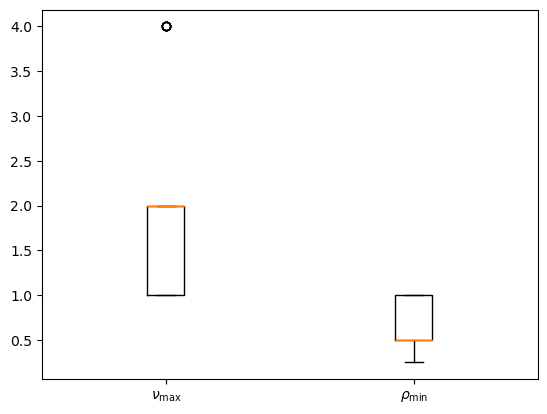

In [4]:
# plot box plot of nuk and rhok
import matplotlib.pyplot as plt
plt.boxplot([nuk_lst, rhok_lst], labels=[r'$\nu_{\max}$', r'$\rho_{\min}$'])
plt.savefig('nuk_rhok_boxplot.pdf', dpi=100)
plt.show()

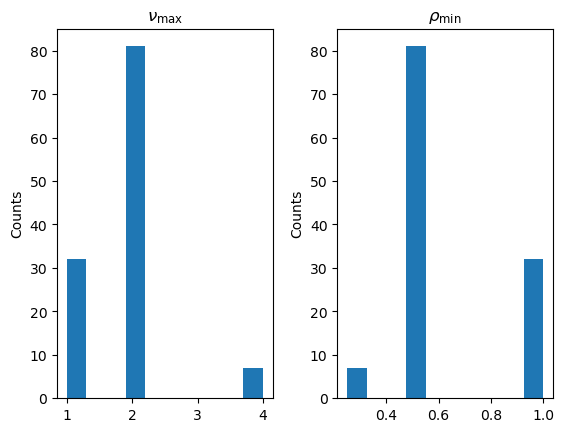

In [24]:
# organuze nuk and rhok into a dataframe
import pandas as pd
df = pd.DataFrame({r'$\nu_{\max}$':nuk_lst, r'$\rho_{\min}$':rhok_lst})
# plot a histogram of nuk and rhok and add custom xticks
axarr = df.hist(bins=10, grid=False)
for ax in axarr.flatten():
    ax.set_ylabel("Counts")
plt.savefig('nuk_rhok_frequency.pdf', dpi=100)